In [11]:
# Load data 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)
# Load MNIST dataset
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# split train data in two
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

Xtrain = Xtrain[0:30000, :, :];
Ytrain = Ytrain[0:30000]

# downsample
factor = 0.25

Xtrain_down = np.ones((Xtrain.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtrain.shape[0]):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)
    
# # *** VECTORIZE IMAGES ***
Xtrain_down = Xtrain_down.reshape(Xtrain_down.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtest_down = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down = X_pr_down.reshape(X_pr_down.shape[0], int(xdim*factor)**2).astype('float32') / 255

Ytrain_cat = np_utils.to_categorical(Ytrain, 10)
Ytest_cat = np_utils.to_categorical(Ytest, 10)

# # Load NN and get output values
# from keras import backend as K
# from keras.models import load_model

# model = load_model('nn.h5')

# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function




In [13]:
# *** TRAIN A FULLY-CONNECTED NN WITH TWO HIDDEN LAYERS ***
# create model
model = Sequential()
model.add(Dense(100, input_shape=(int(xdim*factor)**2,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(Xtrain_down, Ytrain_cat, nb_epoch=50, batch_size=16)

# evaluate the model
scores = model.evaluate(Xtest_down, Ytest_cat, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/50
30000/30000 [==============================] - 3s - loss: 0.4688 - acc: 0.8581     
Epoch 2/50
30000/30000 [==============================] - 2s - loss: 0.2270 - acc: 0.9289     
Epoch 3/50
30000/30000 [==============================] - 2s - loss: 0.1785 - acc: 0.9442     
Epoch 4/50
30000/30000 [==============================] - 2s - loss: 0.1538 - acc: 0.9508     
Epoch 5/50
30000/30000 [==============================] - 2s - loss: 0.1342 - acc: 0.9575     
Epoch 6/50
30000/30000 [==============================] - 3s - loss: 0.1210 - acc: 0.9612     
Epoch 7/50
30000/30000 [==============================] - 2s - loss: 0.1115 - acc: 0.9630     
Epoch 8/50
30000/30000 [==============================] - 2s - loss: 0.0997 - acc: 0.9669     
Epoch 9/50
30000/30000 [==============================] - 2s - loss: 0.0959 - acc: 0.9680     
Epoch 10/50
30000/30000 [==============================] - 2s - loss: 0.0875 - acc: 0.9715     
Epoch 11/50
30000/30000 [========================

In [54]:
# subsample and do xgboost regression
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData

import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'
# scale weight of positive examples
params['eta'] = 0.4
params['max_depth'] = 5
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = 10
num_round=5


# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
subnetSize = range(1,100,5)
nSubnetSize = len(subnetSize)
# which layers?
# how many samples per recording?
nSamples = np.divide(int(X_pr_down.shape[0]/nRecordings),subnetSize)
# how many iterations
nIterations = 50

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    nLayerNeurons = [subnetSize[ss], 0, 0, 10]
    print(subnetSize[ss])
    for it in range(nIterations):
        # copy data
        layer_outputs = deepcopy(layer_outs)
        # subsample
        X_subsample, Y_subsample = RE_PartialRecData(layer_outputs, nLayerNeurons, nRecordings, nSamples[ss])
        #print('# nan neurons: ',np.count_nonzero(np.isnan(X_subsample[:3000,:]).sum(axis=0)))
        # prepare data for xgboost
        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_subsample, label=Y_subsample[:, iN])
            xg_test   = xgb.DMatrix(layer_outs_test[0], label=layer_outs_test[3][:,iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=False)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it,iN,ss] = np.sqrt(np.mean(np.square([(pred[i] - layer_outs_test[3][:,iN][i]) 
                                         for i in range(len(layer_outs_test[3][:,1]))])))
            #print ('predicting, RMSE=%f' %rmses[it, iN, ss])

            

# save the rmse's
import pickle

with open('RMSE_layer1.dat','wb') as f:
    pickle.dump(rmses, f)
f.close()

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96


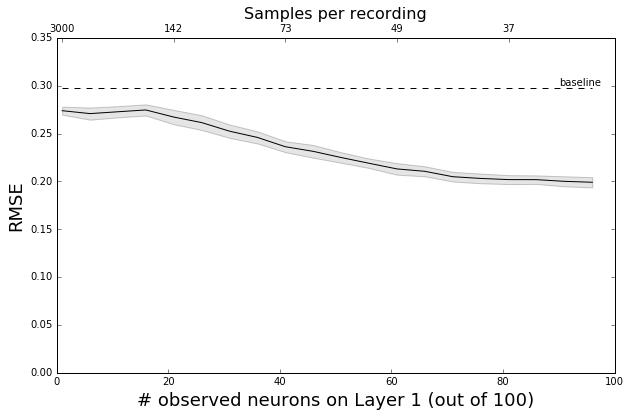

In [103]:
import pickle

with open('RMSE_layer1.dat','r') as f:
    rmses = pickle.load(f)
f.close()

import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

fig=pl.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0, 100])
ax2 = ax1.twiny()

x = subnetSize;
y = np.mean(np.mean(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'k--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

ax1.set_xlabel('# observed neurons on Layer 1 (out of 100)', fontsize=18)
ax2.set_xlabel('Samples per recording',  fontsize=16)

new_tick_locations =range(1, 100, 20)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(nSamples[range(0, 20, 4)])


# ax2.set_xticks(nSamples)
# ax2.set_xticklabels(nSamples[range(0, 5, 20)])
ax1.set_ylabel('RMSE', fontsize=18)
ax1.set_ylim([0, .35])

pl.text(90,0.3, 'baseline')

# #pl.title('%d recordings'%(nRecordings), fontsize=18)
# #pl.title(nRecordings ' recordings ')
#pl.show()
#pl.draw()
pl.savefig('RMSEs_Layer_1.eps', format='eps', dpi=1000)
pl.savefig('RMSEs_Layer_1.png', format='png')



In [62]:
# subsample and do xgboost regression
from copy import copy, deepcopy
from RE_PartialRecData import RE_PartialRecData

import os
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier
import time


params = {}
# use softmax multi-class classification 'multi:softmax'
# use linear regression 'reg:linear'
params['objective'] = 'reg:linear'
# scale weight of positive examples
params['eta'] = 0.4
params['max_depth'] = 5
params['silent'] = 1
params['nthread'] = 4
# params['num_class'] = 10
num_round=5
# how many recordings?
nRecordings = 10
# how many neurons from the firs hidden layer?
subnetSize = range(1,100,5)
nSubnetSize = len(subnetSize)
# which layers?
# how many samples per recording?
nSamples = np.divide(int(X_pr_down.shape[0]/nRecordings),subnetSize)
# how many iterations
nIterations = 50

# baseline prediction error
#bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

oLayer = len(layer_outs)-1  # index of output layer
nOutNeurons = layer_outs[oLayer].shape[1]
rmses = np.zeros([nIterations, nOutNeurons, nSubnetSize])

for ss in range(nSubnetSize):
    nLayerNeurons = [0, subnetSize[ss], 0, 10]
    start = time.time()

    for it in range(nIterations):
        # copy data
        layer_outputs = deepcopy(layer_outs)
        # subsample
        X_subsample, Y_subsample = RE_PartialRecData(layer_outputs, nLayerNeurons, nRecordings, nSamples[ss])
        #print('# nan neurons: ',np.count_nonzero(np.isnan(X_subsample[:3000,:]).sum(axis=0)))
        # prepare data for xgboost
        for iN in range(nOutNeurons):
            #print('#neuron, #iteratin, subnetsize: ', iN,it,subnetSize[ss])
            xg_train  = xgb.DMatrix(X_subsample, label=Y_subsample[:, iN])
            xg_test   = xgb.DMatrix(layer_outs_test[1], label=layer_outs_test[3][:,iN])
            watchlist = [(xg_train, 'train'), (xg_test, 'test')]
            # train XGboost
            bst = xgb.train(params, xg_train, num_round, watchlist, verbose_eval=False)
            # get predictions
            pred = bst.predict(xg_test)
            rmses[it,iN,ss] = np.sqrt(np.mean(np.square([(pred[i] - layer_outs_test[3][:,iN][i]) 
                                         for i in range(len(layer_outs_test[3][:,1]))])))
            # run your code
    end = time.time()
    elapsed = end - start
    print(subnetSize[ss],elapsed,X_subsample.shape[0])

# save the rmse's
import pickle
with open('RMSE_layer2.dat','wb') as f:
    pickle.dump(rmses, f)
f.close()

(1, 20.8608980178833)
(6, 13.724399089813232)
(11, 13.059033870697021)
(16, 12.846776962280273)
(21, 12.704290866851807)
(26, 12.645793914794922)
(31, 12.587541103363037)
(36, 12.554749965667725)
(41, 12.522727012634277)
(46, 12.500791788101196)
(51, 12.448332071304321)
(56, 12.459762811660767)
(61, 12.412487030029297)
(66, 12.343886852264404)
(71, 12.30042815208435)
(76, 12.21862006187439)
(81, 12.15907597541809)
(86, 12.032851934432983)
(91, 11.859812021255493)
(96, 11.659088134765625)


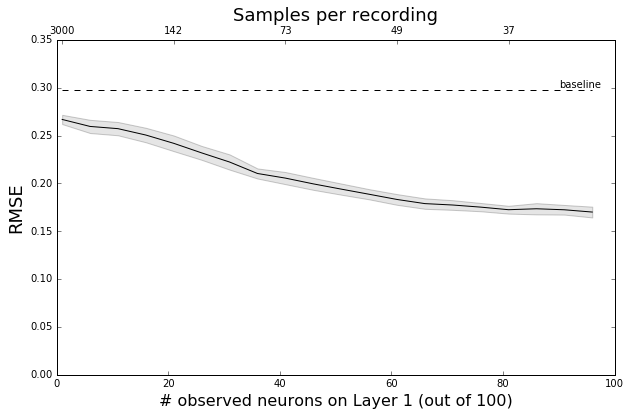

In [98]:
import pickle

with open('RMSE_layer2.dat','r') as f:
    rmses = pickle.load(f)
f.close()

import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np

fig=pl.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim([0, 100])
ax2 = ax1.twiny()

x = subnetSize;
y = np.mean(np.mean(rmses, axis=1), axis=0)
error = np.std(np.mean(rmses, axis=1), axis=0)
bl = np.std(layer_outs_test[oLayer]-np.mean(layer_outs_test[oLayer]));

pl.plot(x, y, 'k-')
horiz_line_data = np.array([bl for i in xrange(len(x))])
pl.plot(x, horiz_line_data, 'k--') 
pl.fill_between(x, y-error, y+error, alpha=0.2, facecolor='#808080')

ax1.set_xlabel('# observed neurons on Layer 1 (out of 100)', fontsize=16)
ax2.set_xlabel('Samples per recording',  fontsize=18)

new_tick_locations =range(1, 100, 20)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(nSamples[range(0, 20, 4)])


# ax2.set_xticks(nSamples)
# ax2.set_xticklabels(nSamples[range(0, 5, 20)])
ax1.set_ylabel('RMSE', fontsize=18)
ax1.set_ylim([0, .35])

plt.text(90,0.3, 'baseline')

# #pl.title('%d recordings'%(nRecordings), fontsize=18)
# #pl.title(nRecordings ' recordings ')
pl.show()
plt.savefig('RMSEs_Layer_2.eps', format='eps', dpi=1000)




In [74]:
nSamples[[1, 6, 10]]

array([500,  96,  58])